In [65]:
#Import you usual Libraries
import numpy as np
import time
import matplotlib.pyplot as plt
from Driven_Gaus_Poly1_DDF import *
from matplotlib.animation import FuncAnimation

# Data Preperation

In [66]:
#Import the Data
SWE = np.load('ForcedSWE_20k_1e-1.npy')

In [67]:
SWE.shape
#It goes Dimension (u,v,z), Y, X, then time

(3, 10, 10, 20000)

In [68]:
#Here I reorganize my data into Dimension by Time
SWE_DDF = np.zeros((300,20000))
for d in range(3):
    for i in range(10):
        for j in range(10):
            SWE_DDF[j+10*i+100*d] = SWE[d][i][j]

In [69]:
#This is specific to the forcing I used when I generated my data
Nx = 10 #Number of data points along x axis
Ny = 10 #Number of data points along y axis

Lx = Nx*100e3
Ly = Ny*100e3
Force_0 = 1e-5
x = np.linspace(0, Lx, Nx)  # Array with x-points
y = np.linspace(0, Ly, Ny)  # Array with y-points
X, Y = np.meshgrid(x, y)              # Meshgrid
Y = Y[::-1, :]

Forcing = np.zeros((Nx*Ny*3,20000))
Force_0 = 1e-5
for i in range(Ny):
    for j in range(Nx):
        Forcing[j+i*Nx] = -Force_0*np.cos(2*np.pi*Y[i,j]/Ly)
Forcing[0:21]

array([[-1.00000000e-05, -1.00000000e-05, -1.00000000e-05, ...,
        -1.00000000e-05, -1.00000000e-05, -1.00000000e-05],
       [-1.00000000e-05, -1.00000000e-05, -1.00000000e-05, ...,
        -1.00000000e-05, -1.00000000e-05, -1.00000000e-05],
       [-1.00000000e-05, -1.00000000e-05, -1.00000000e-05, ...,
        -1.00000000e-05, -1.00000000e-05, -1.00000000e-05],
       ...,
       [-7.66044443e-06, -7.66044443e-06, -7.66044443e-06, ...,
        -7.66044443e-06, -7.66044443e-06, -7.66044443e-06],
       [-7.66044443e-06, -7.66044443e-06, -7.66044443e-06, ...,
        -7.66044443e-06, -7.66044443e-06, -7.66044443e-06],
       [-1.73648178e-06, -1.73648178e-06, -1.73648178e-06, ...,
        -1.73648178e-06, -1.73648178e-06, -1.73648178e-06]])

# Training and Forecasting

In [9]:
D = 300              #Dimension of the system
length = 10000       #Time to train for
Xdata = SWE_DDF    #Which Data set to train on
h = 0.1             #Time Scale of the Data
NoCenters = 1000     #Number of Centers


start_time = time.time()
DDF = GaussPoly1Mat()
Center = DDF.KmeanCenter(Xdata,NoCenters,D,length)
print("--- %s seconds ---" % (time.time() - start_time))
np.save('Centers_train10k_1k_D300.npy',Center)
#Center = np.load('Centers_train10k_1k_D300.npy')

In [49]:
PreLength = 5000    #Forecasting Time
beta,R = 1e-6, 1e-12 #Hyper Parameters Beta and R (Very Important!)
Force = Forcing.T   #Choose the forcing to be used (input it as: Time by Dimension)

X = np.arange(0,PreLength*h,h)
start_time = time.time()
F = DDF.FuncApproxF(Xdata,length,Center,beta,R,D,Force,h)
print("--- %s seconds ---" % (time.time() - start_time))
Pred = DDF.PredictIntoTheFuture(F,PreLength,DDF.FinalX,Force,h)
print("--- %s seconds ---" % (time.time() - start_time))

--- 8.931559085845947 seconds ---
--- 12.831474781036377 seconds ---


<function matplotlib.pyplot.show(close=None, block=None)>

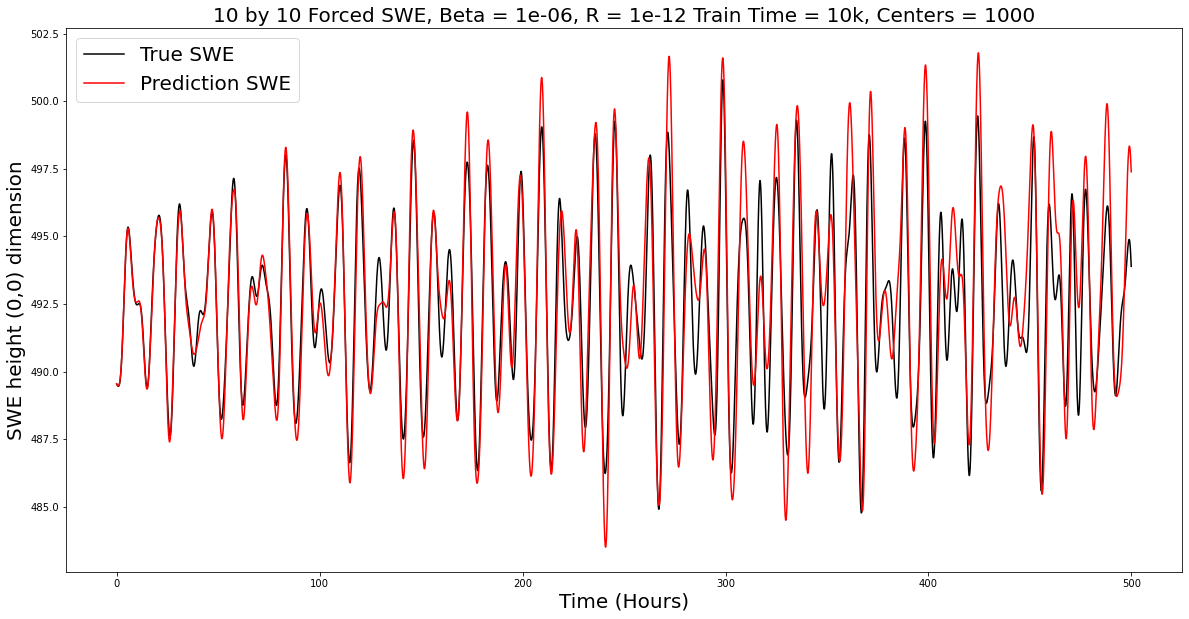

In [50]:
plt.figure(figsize=(20,10))
plt.plot(X,Xdata[200][length:length + PreLength],label = 'True SWE', color = 'black')
plt.plot(X,Pred[200],label = 'Prediction SWE', color = 'r')
plt.xlabel('Time (Hours)',fontsize=20)
plt.ylabel('SWE height (0,0) dimension',fontsize=20)
plt.legend(fontsize=20)
plt.title('10 by 10 Forced SWE, Beta = '+str(beta)+', R = '+str(R)+' Train Time = 10k, Centers = 1000',fontsize=20)
plt.savefig('10by10_Forced_Wind_SWE')
plt.show

In [51]:
np.savetxt('PredictionData.txt',Pred.T)
np.savetxt('TrueData.txt',Xdata.T[length:length + PreLength])

In [70]:
for i in range(15):
    for j in range(15):
        PreLength = 5000
        X = np.arange(0,PreLength*h,h)
        beta,R = 10**(i-12), 10**(j-12)
        
        F = DDF.FuncApproxF(Xdata,length,Center,beta,R,D,Force,h)
        Pred = DDF.PredictIntoTheFuture(F,PreLength,DDF.FinalX,Force,h)
        
        if True not in np.isnan(Pred):  #This just makes sure there aren't infinities in the prediction because matlab will return an error and stop the looping
            plt.figure(figsize=(20,10))
            plt.plot(X,Xdata[0][length:length + PreLength],label = 'True SWE', color = 'black')
            plt.plot(X,Pred[0],label = 'Prediction SWE', color = 'r')
            plt.xlabel('Time (Hours)',fontsize=20)
            plt.ylabel('SWE x velocity',fontsize=20)
            plt.legend()
            plt.title('SWE 0.1 time step, Beta = '+str(beta)+', R = '+str(R)+' Train Time = 10000, Centers = 1000',fontsize=20)
            plt.savefig('Ploti='+str(i)+'j='+str(j))
            #plt.show

# Prediction Animation

In [52]:
DZ = 200 #This is the dimension the water height starts at (0-399 u, 400-799 v, 800-1199 z)
Zpred = Pred[DZ:]
ZTrue = Xdata[DZ:]
space = 10   #Tell Matlab the square grid size (in this case a 3 by 3)
stepsize = 5 #Choose how many time steps to skip before adding a new frame to the video
Frames = 1000 #Number of Frames in the video
minlevel = 485 #Water height level min
maxlevel = 505 #Water height level max


#Make the Prediction Animation
x = np.arange(0,space,1)
y = np.arange(0,space,1)
X,Y = np.meshgrid(x, y)
Z = np.zeros((space,space))
ZP = np.zeros((space,space))
ZT = np.zeros((space,space))

def animateppred(i):
    ax.clear()
    ax.set_title('DDF Surface')
    ax.set_zlim(minlevel,maxlevel)
    for j in range(space):
        for l in range(space):
            ZP[j][l] = Zpred[j*space+l][i*stepsize]
    ax.plot_surface(X, Y, ZP, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

#Make the True Animation
def animatepTrue(i):
    ax.clear()
    ax.set_title('True Surface')
    ax.set_zlim(minlevel,maxlevel)
    for j in range(space):
        for l in range(space):
            ZT[j][l] = ZTrue[j*space+l][length+i*stepsize]
    ax.plot_surface(X, Y, ZT, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    
    
#1 Wire Frame and 1 Surface
X,Y = np.meshgrid(x, y)
Z1 = np.zeros((space,space))
Z2 = np.zeros((space,space))

def animatepBoth(i):
    ax.clear()
    ax.set_title('True Surface')
    ax.set_zlim(minlevel,maxlevel)
    for j in range(space):
        for l in range(space):
            Z1[j][l] = ZTrue[j*space+l][length+i*stepsize]
    for j in range(space):
        for l in range(space):
            Z2[j][l] = Zpred[j*space+l][i*stepsize]
    
    ax.plot_surface(X, Y, Z1, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    #ax.plot_surface(X, Y, Z2, rstride=1, cstride=1,
    #                cmap='binary', edgecolor='none')
    ax.plot_wireframe(X, Y, Z2, color='black')
    ax.set_title('surface');

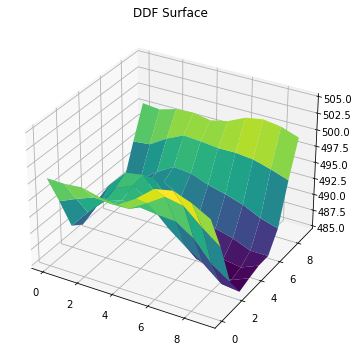

In [53]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection='3d')
ani = FuncAnimation(fig, animateppred, frames=Frames, interval=50, repeat=False)

ani.save('Pred_SWE_Forced.mp4',writer = 'ffmpeg',fps=30)

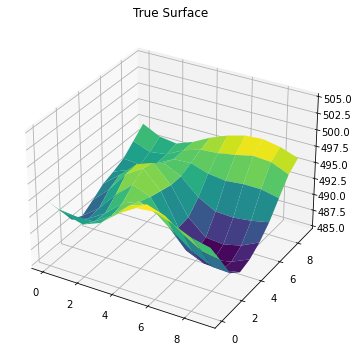

In [54]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection='3d')
ani = FuncAnimation(fig, animatepTrue, frames=Frames, interval=50, repeat=False)

ani.save('True_SWE_Forced.mp4',writer = 'ffmpeg',fps=30)

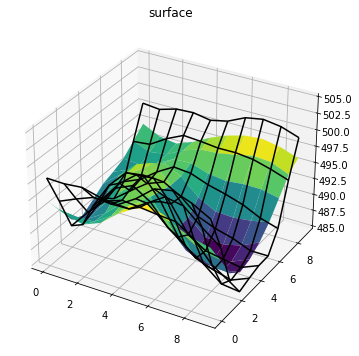

In [55]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection='3d')
ani = FuncAnimation(fig, animatepBoth, frames=Frames, interval=50, repeat=False)

ani.save('Both_SWE_Forced.mp4',writer = 'ffmpeg',fps=30)

# 3D Picture

In [44]:
Zpred = Pred[200:]
Zpred.shape

(100, 5000)

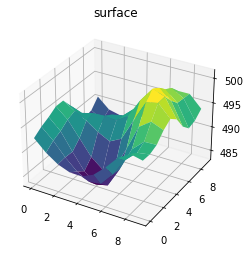

In [46]:
i = 1000
space = 10
x = np.arange(0,space,1)
y = np.arange(0,space,1)
X,Y = np.meshgrid(x, y)
Z = np.zeros((space,space))
for j in range(space):
    for l in range(space):
        Z[j][l] = Zpred[j*space+l][i]

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface');